# Выбор локации для скважины

## Введение

Добывающая компания «ГлавРосГосНефть» хочет узнать, где бурить новую скважину. В нескольких регионах собрали характеристики для скважин: качество нефти и объем её запасов. Необходимо определить регион с максимальной суммарной прибылью отобранных скважин.

**Входные данные**
* Для обучения модели подходит только линейная регрессия.
* При разведке региона исследуют 500 точек, из которых нужно выбрать 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Ход работы**

Компанией предоставлены датафремы с данными от каждого из трёх регионов. Для начала необходимо загрузить данные и изучить их. Данные необходимо проверить на пропуски и дубликаты.

Следующей частью работы станет исследовательский анализ данных. По каждому датасету посмотрим, есть ли корреляция между данными. Также проверим данные на выбросы и изучим гистограммы.

Затем можно будет перейти к обучению модели. Данные разделим на обучающую и валидационную выборки. Все модели обучим, а затем для данных каждого региона найдём: реальный средний запас сырья, предсказанный средний запас сырья и среднеквадратическую ошибку RMSE.

Подготовимся к расчету прибыли. Зададим переменные для входных значений. Определим достаточный объём сырья для безубыточной разработки новой скважины. Найдем средний запас в каждом регионе. Далее необходимо будет точечно выявить выгодные скважины в каждом регионе. Рассчитаем прибыли и риски, учитывая, что компания исследует 500 точек, а разработает 200 лучших.


Наконец перейдём к выявлению наиболее выгодных скважин в каждом регионе. Рассчитаем прибыли и риски, учитывая, что компания исследует 500 точек, а разработает 200 лучших.

## Загрузка и подготовка данных

### Загрузка данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Загрузка данных

In [2]:
data1 = pd.read_csv('/datasets/geo_data_0.csv')
data2 = pd.read_csv('/datasets/geo_data_1.csv')
data3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
dframes = {
    '1': data1,
    '2': data2,
    '3': data3
}

for i, j in dframes.items():
    print('Данные по региону', i)
    display(j.head())
    display(j.describe())
    print()

Данные по региону 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Данные по региону 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Данные по региону 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Нам предоставлены три датасета - пробы нефти в трёх регионах.
Описание столбцов в каждом датасете:
* **id** — уникальный идентификатор скважины;
* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
* **product** — объём запасов в скважине (тыс. баррелей).

Данные в столбцах f0, f1, f2 синтетические: характеристики месторождений не разглашаются.

### Пропуски

Изучим информацию о датасетах.

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Ни в одном датасете нет пропущенных значений.

### Дубликаты

Проверим данные на явные дубликаты по столбцу id, т.к. это уникальный идентификатор.

In [7]:
data1.duplicated(subset=['id']).sum()

10

In [8]:
data2.duplicated(subset=['id']).sum()

4

In [9]:
data3.duplicated(subset=['id']).sum()

4

Во всех датасетах обнаружены дубликаты. Посмотрим, есть ли дубликаты по сумме параметров.

In [10]:
data1.duplicated(subset=['id', 'f0', 'f1', 'f2', 'product']).sum()

0

In [11]:
data2.duplicated(subset=['id', 'f0', 'f1', 'f2', 'product']).sum()

0

In [12]:
data3.duplicated(subset=['id', 'f0', 'f1', 'f2', 'product']).sum()

0

По сумме параметров дубликаты не обнаружены. Неизвестно с чем связаны дубликаты. Получается, что с некоторых скважин пробы брали несколько раз. Посмотрим на повторяющиеся данные.

In [13]:
data1[data1.id.duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [14]:
data2[data2.id.duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [15]:
data3[data3.id.duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Дубликаты могут повлиять на результат. Характеристики одной и той же скважины отличаются. Но, с другой стороны, у нас нет возможности уточнить данные, поэтому оставим дубликаты как есть.

### Вывод

В данном разделе были загружены и изучены предоставленные данные. В каждом датасете присутствуют следующие данные:

* **id** — уникальный идентификатор скважины;
* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
* **product** — объём запасов в скважине (тыс. баррелей).

Данные в столбцах **f0, f1, f2** синтетические: характеристики месторождений не разглашаются.

Пропущенные значения в данных не найдены. Также данные были проверены на дубликаты. В каждом датафрейме найдены дубликаты по уникальному идентификатору. Получается, что из некоторых скважин пробы брали несколько раз. По сумме ключевых параметров дубликаты не найдены. Т.к. нет возможности уточнить, какие данные верные, а какие нет, было принято решение дубликаты не трогать.

## Исследовательский анализ данных

### Корелляция

По каждому датасету посмотрим, есть ли корреляция между данными.

In [16]:
def korr(data):
    plt.figure(figsize=(15, 10))
    sn.heatmap(data.corr(), annot=True, cmap='GnBu', cbar=False, robust=True, linewidths=.2)
    plt.show()

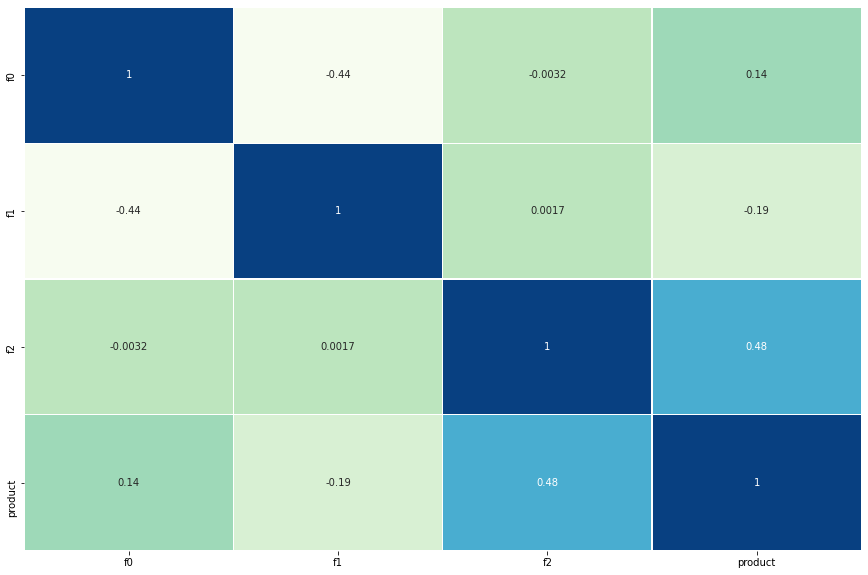

In [17]:
korr(data1)

Наблюдается умеренная положительная корреляция между объемом запасов скважин и столбцом f2, а также умеренная отрицательная корреляция между признаками f0 и f1.

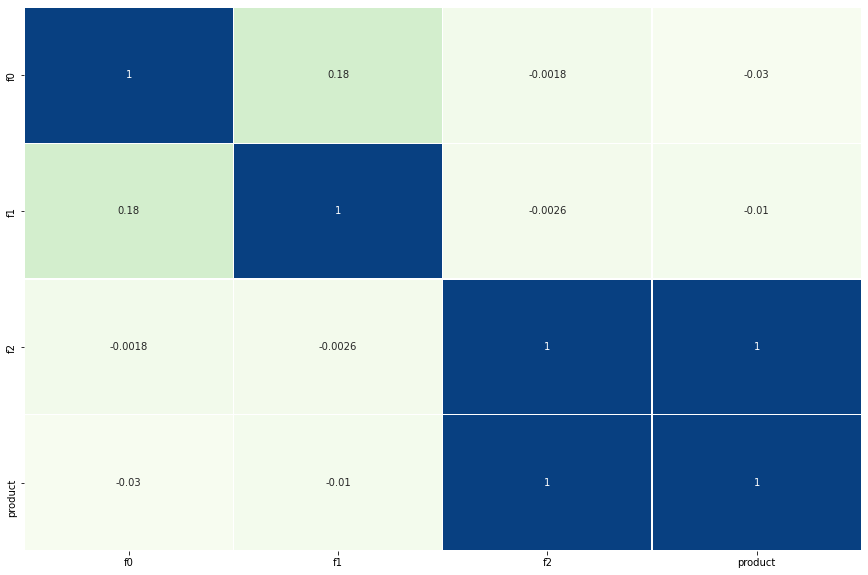

In [18]:
korr(data2)

Наблюдается весьма высокая корреляция между объемом запасов скважин и столбцом f2.

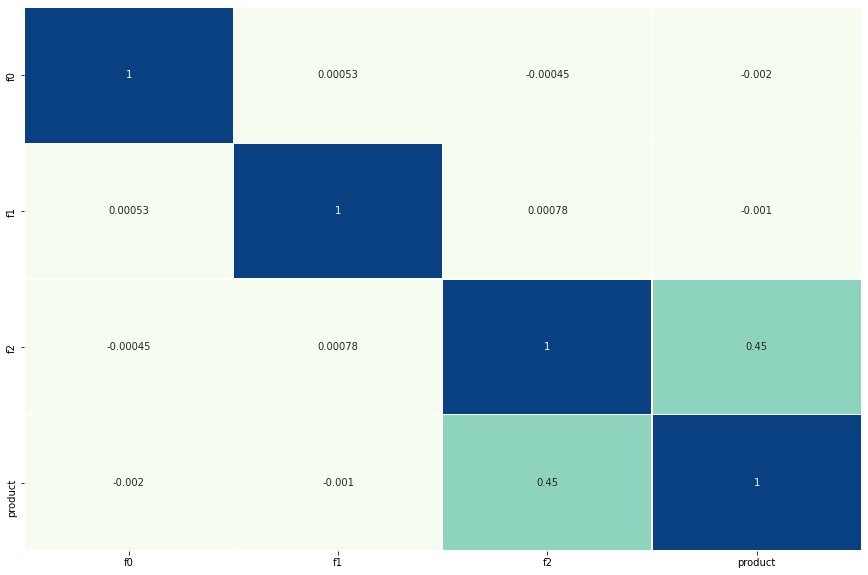

In [19]:
korr(data3)

Наблюдается умеренная корреляция между объемом запасов скважин и столбцом f2.

### Выбросы

Создадим функции для построения графиков, которые помогут определить выбросы в данных.

In [20]:
def boxplot_graf(data, name):
    box = plt.boxplot(
        x=data, vert=False, 
        patch_artist=True,  
        boxprops = dict(facecolor = "#35c0cd")
    )
    fig = plt.gcf()
    fig.set_size_inches(20, 5)
    plt.title(
            f'Боксплот признака {name}', 
            fontsize=14
        )
    plt.show()
    print()
    z1 = data.quantile(0.25)
    z3 = data.quantile(0.75)
    r = z3 - z1
    lower = z1 - (1.5 * r)
    upper = z3 + (1.5 * r)
    print()
    print('\033[1m' + f'Пороговые значения {name}:' + '\033[0m')
    print('Нижняя граница значений:', lower)
    print('Верхняя граница значений:', upper)

In [21]:
def hist_graf(data, name, title, y_name, x_name, bins):
    print()
    print('\033[1m' + f'Описание признака {name}:' + '\033[0m')
    print()
    print(data.describe())
    print()
    
    data.plot(
        kind='hist', 
        title=title, 
        bins=bins, 
        grid=True, 
        figsize = (15,8),
        color = '#35c0cd',
        edgecolor='black');
    plt.ylabel(y_name)
    plt.xlabel(x_name);

#### Регион 1


Описание признака f0:

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64



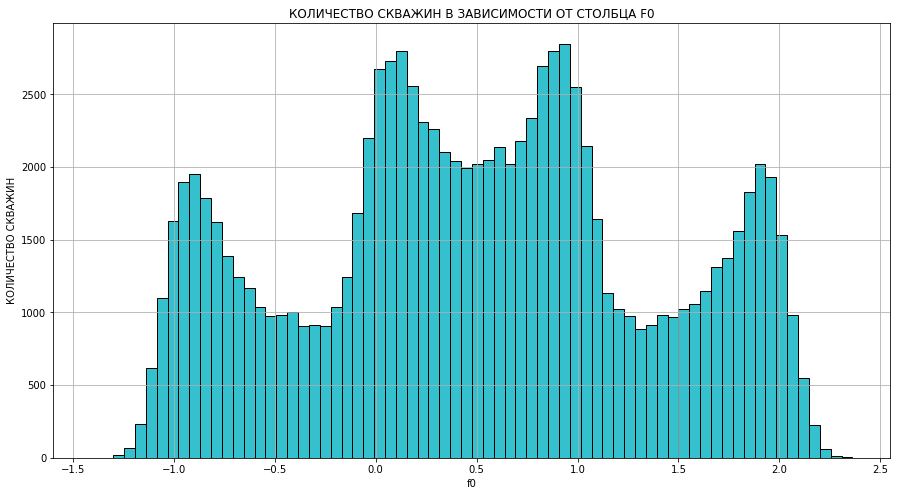

In [22]:
hist_graf(data1['f0'], 
          'f0', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F0', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f0', 
          70)

Минимальное значение: -1.4, максимальное: 2.3. Гистограмма мультимодальна. Медиана и среднее близки, скорее всего, выбросов нет. Однако, учитывая предоставленные данные, сложно судить, какие значения являются близкими, а какие нет. Проверим наличие выбросов.

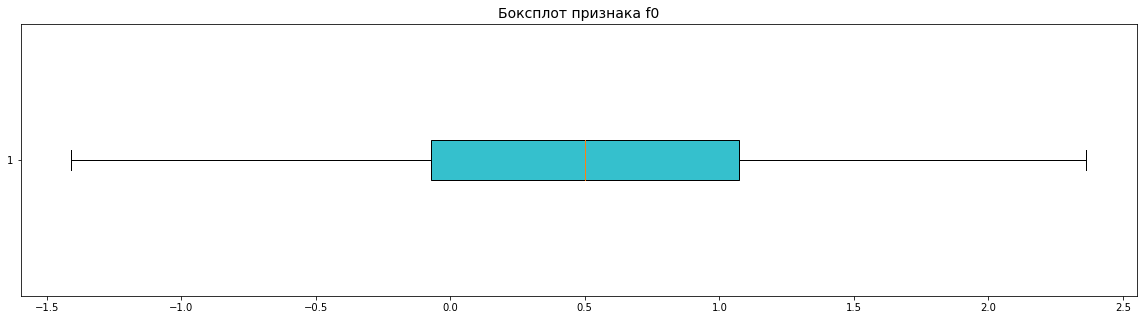



Пороговые значения f0:
Нижняя граница значений: -1.791823168535949
Верхняя граница значений: 2.792824148989128


In [23]:
boxplot_graf(data1['f0'], 'f0')

Выбросов нет.


Описание признака f1:

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64



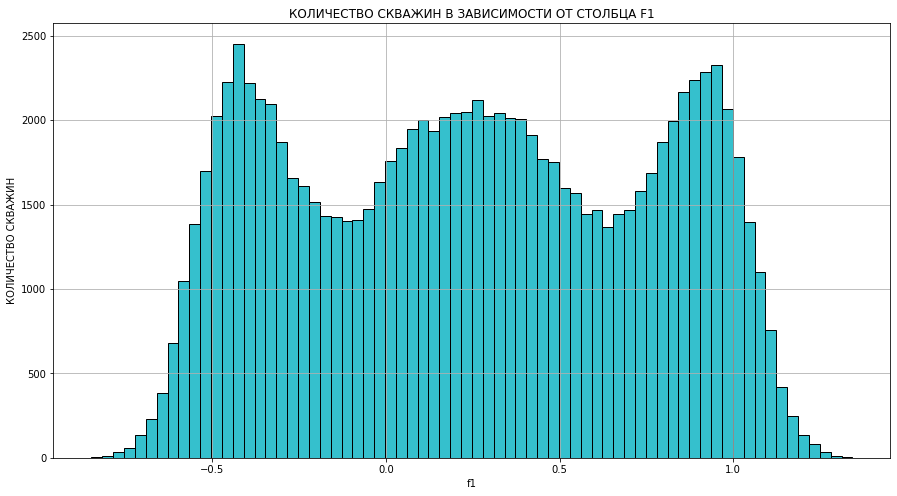

In [24]:
hist_graf(data1['f1'], 
          'f1', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F1', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f1', 
          70)

Минимальное значение: -0.8, максимальное: 1.3. Гистограмма мультимодальна. Медиана и среднее близки.

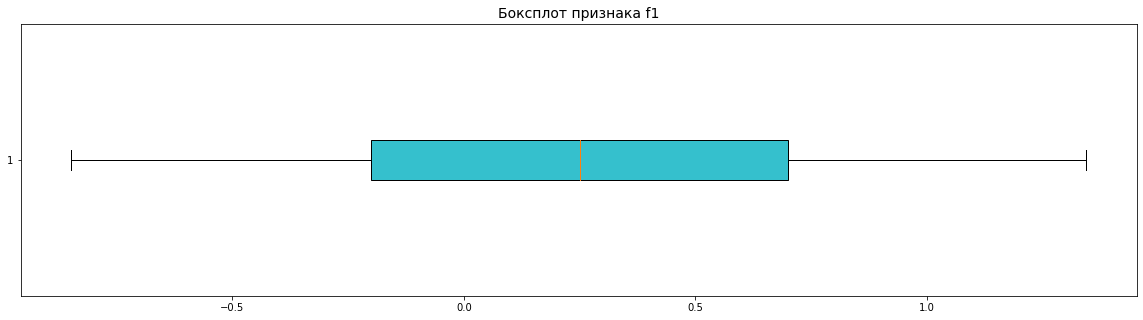



Пороговые значения f1:
Нижняя граница значений: -1.5531725709976618
Верхняя граница значений: 2.052937789619416


In [25]:
boxplot_graf(data1['f1'], 'f1')

Выбросов нет.


Описание признака f2:

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64



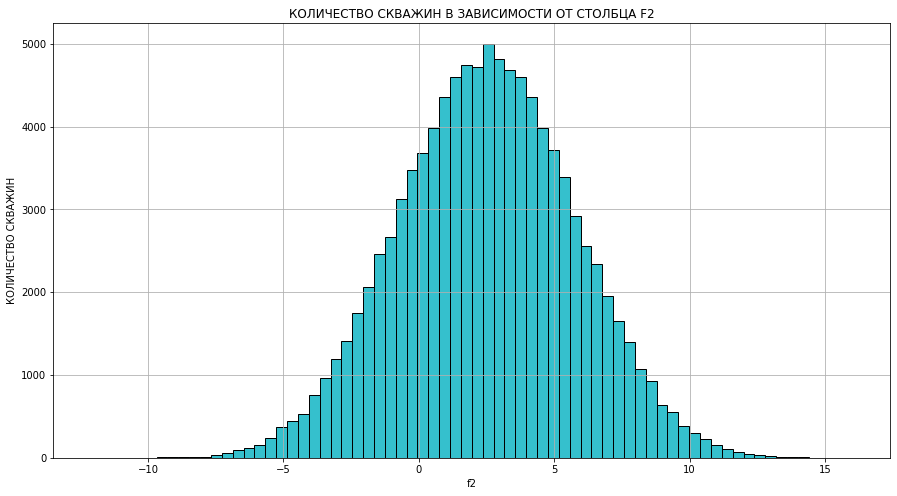

In [26]:
hist_graf(data1['f2'], 
          'f2', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F2', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f2', 
          70)

Минимальное значение: -12, максимальное: 4.7. Гистограмма распределена нормальна. Медиана и среднее близки. Проверим выбросы.

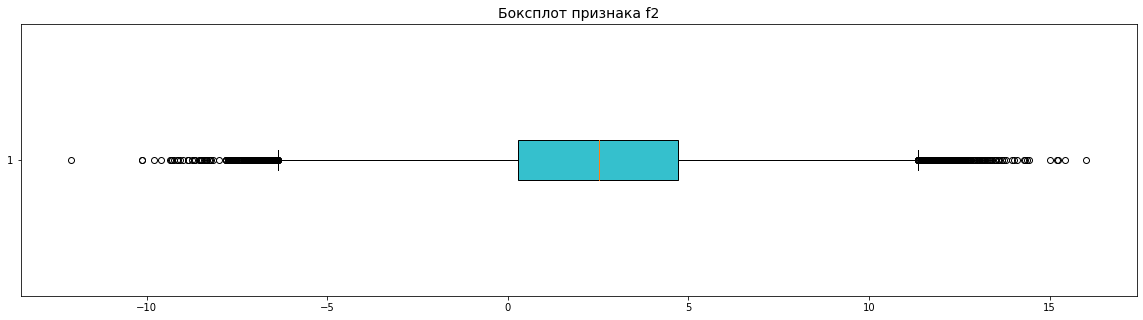



Пороговые значения f2:
Нижняя граница значений: -6.3532614580838125
Верхняя граница значений: 11.356097512311544


In [27]:
boxplot_graf(data1['f2'], 'f2')

In [28]:
len(data1[data1['f2'] < -7]) + len(data1[data1['f2'] > 12])

247

Есть выбросы, 247 строк. Мало скважин с параметрами f2 меньше -7 и больше 12.


Описание признака "объём запасов в скважине":

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64



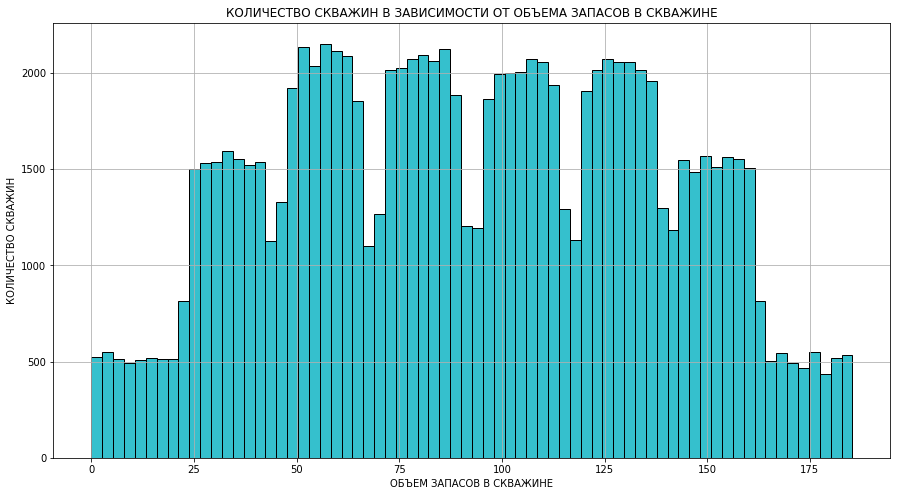

In [29]:
hist_graf(data1['product'], 
          '"объём запасов в скважине"', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ ОБЪЕМА ЗАПАСОВ В СКВАЖИНЕ', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'ОБЪЕМ ЗАПАСОВ В СКВАЖИНЕ', 
          70)

Минимальное значение: 0, максимальное: 185.3. Гистограмма имеет много пиков. Медиана и среднее близки. Есть скважины с нулевым запасом. Проверим, сколько пробных скважины оказались пустыми.

In [30]:
len(data1[data1['product'] == 0])

1

Одна скважина. Часто скважины бурят и там, где нефти нет, чтобы уточнить некоторые параметры. Возможно, в данные попала именно такая скважина. 

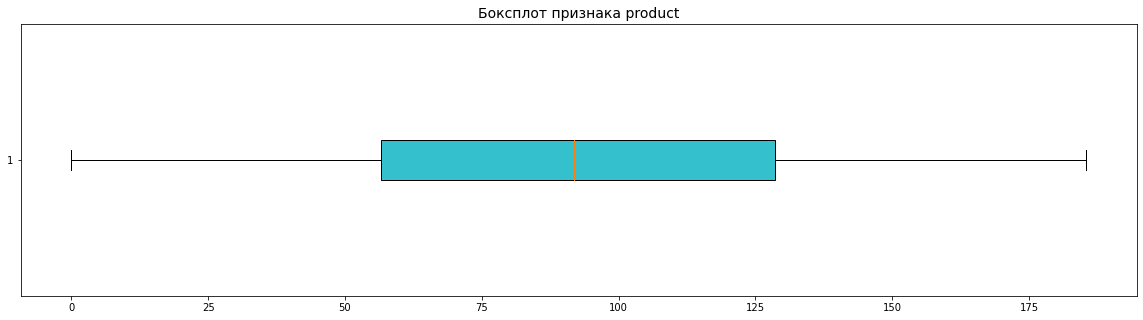



Пороговые значения product:
Нижняя граница значений: -51.60236680760907
Верхняя граница значений: 236.66396243896986


In [31]:
boxplot_graf(data1['product'], 'product')

Выбросов нет.

#### Регион 2


Описание признака f0:

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64



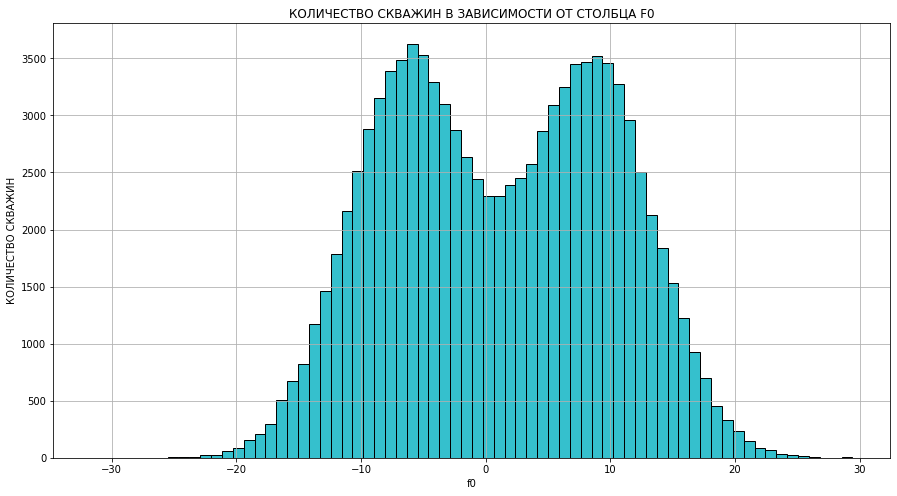

In [32]:
hist_graf(data2['f0'], 
          'f0', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F0', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f0', 
          70)

Минимальное значение: -31.6, максимальное: 29.4. Гистограмма бимодальна. Медиана и среднее близки. Проверим выбросы.

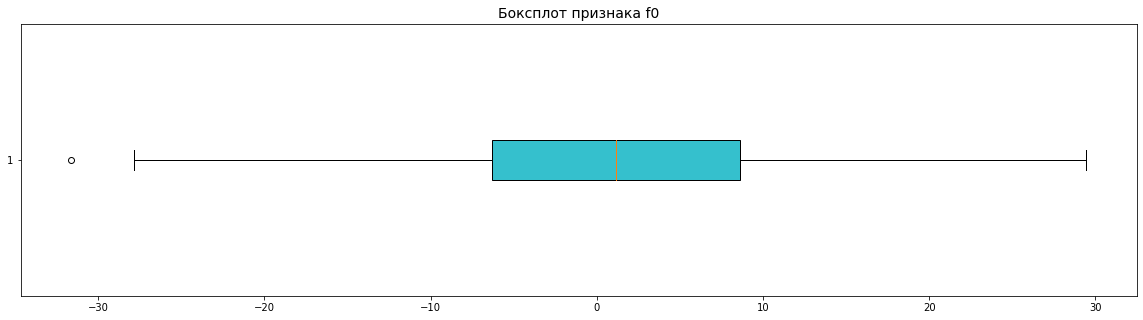



Пороговые значения f0:
Нижняя граница значений: -28.677901128779617
Верхняя граница значений: 31.000365467492706


In [33]:
boxplot_graf(data2['f0'], 'f0')

Выбросов нет.


Описание признака f1:

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64



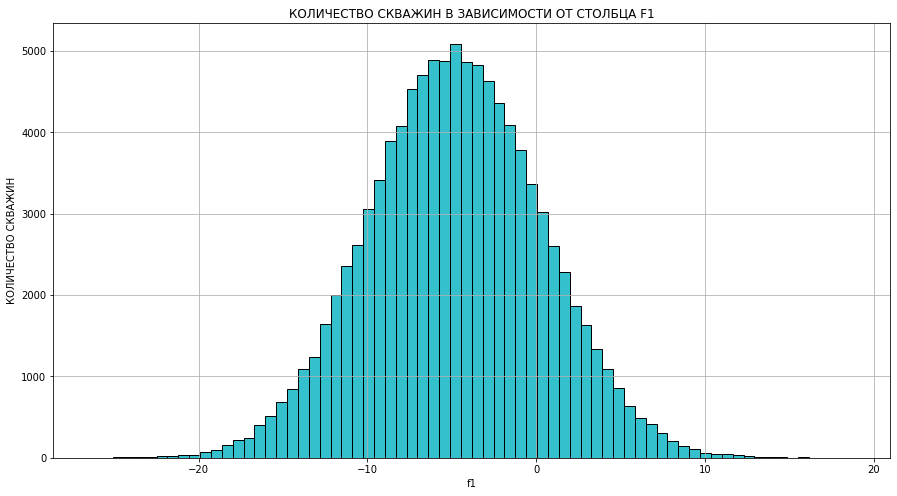

In [34]:
hist_graf(data2['f1'], 
          'f1', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F1', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f1', 
          70)

Минимальное значение: -26.3, максимальное: 18.7. Гистограмма имеет нормальное распределение. Медиана и среднее близки.

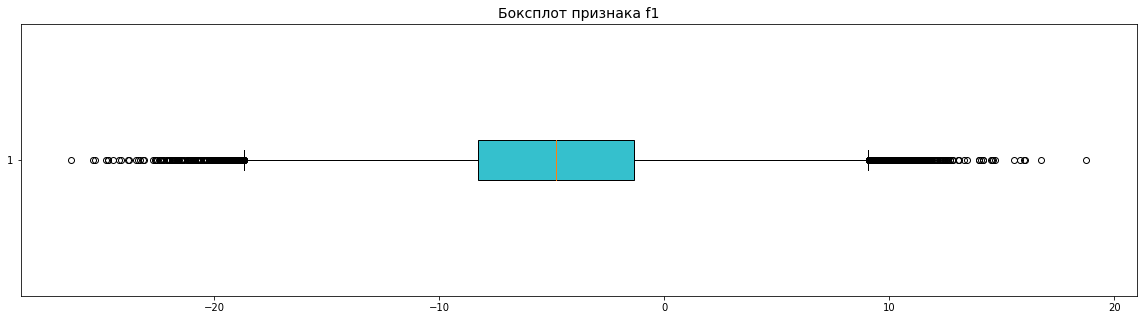



Пороговые значения f1:
Нижняя граница значений: -18.670738069582377
Верхняя граница значений: 9.069937223519565


In [35]:
boxplot_graf(data2['f1'], 'f1')

In [36]:
len(data2[data2['f1'] < -19]) + len(data2[data2['f1'] > 10])

441

Есть выбросы. Относительно мало значений меньше -19 и больше 10.


Описание признака f2:

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64



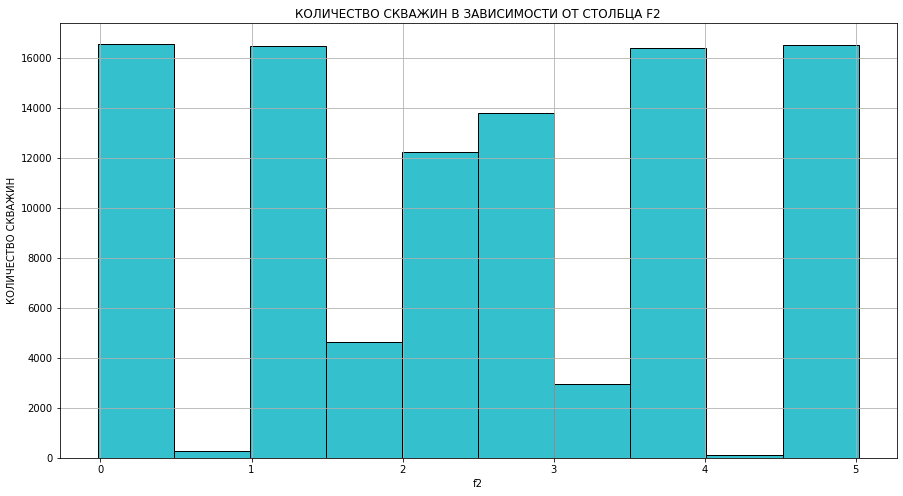

In [37]:
hist_graf(data2['f2'], 
          'f2', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F2', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f2', 
          10)

Минимальное значение: -0.02, максимальное: 5.0. Среднее и медиана близки. Форма распределения случайная, четкой закономерности не прослеживается. Хотя прослеживается симметричность левой и правой части графика. Распределение выглядит как-то подозрительно по сравнению с данными из первого региона. Но т.к. мы не знаем, что это за параметр, других данных у нас нет, оставим все как есть.

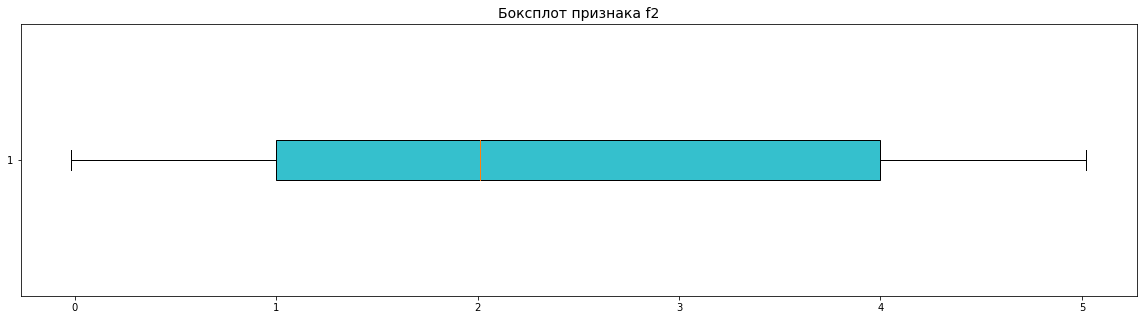



Пороговые значения f2:
Нижняя граница значений: -3.4998028621957973
Верхняя граница значений: 8.499728223745905


In [38]:
boxplot_graf(data2['f2'], 'f2')

Выбросов нет.


Описание признака "объём запасов в скважине":

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64



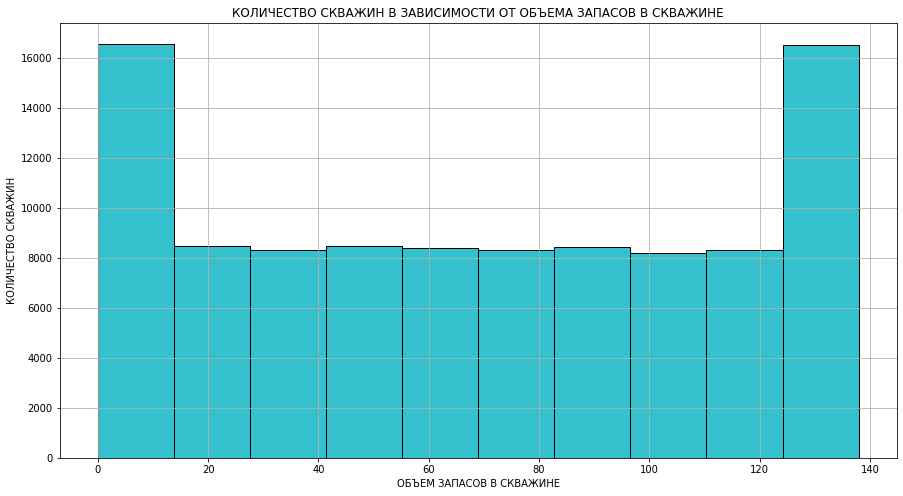

In [39]:
hist_graf(data2['product'], 
          '"объём запасов в скважине"', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ ОБЪЕМА ЗАПАСОВ В СКВАЖИНЕ', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'ОБЪЕМ ЗАПАСОВ В СКВАЖИНЕ', 
          10)

Минимальное значение: 0, максимальное: 137.9. Среднее и медиана отличаются. Два пика: с нулевым значением и со значениями 125-130. Между этими значениями гистограмма однородна. Посмотрим, сколько нулевых значений в данных.

In [40]:
len(data2[data2['product'] == 0])

8235

Очень много скважин с нулевым объемом запасов.

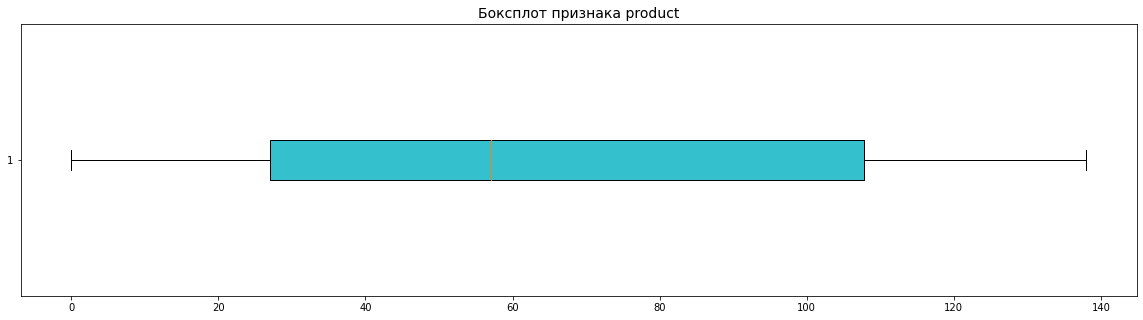



Пороговые значения product:
Нижняя граница значений: -94.33641361038892
Верхняя граница значений: 229.10271876808736


In [41]:
boxplot_graf(data2['product'], 'product')

Выбросов нет.

#### Регион 3


Описание признака f0:

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64



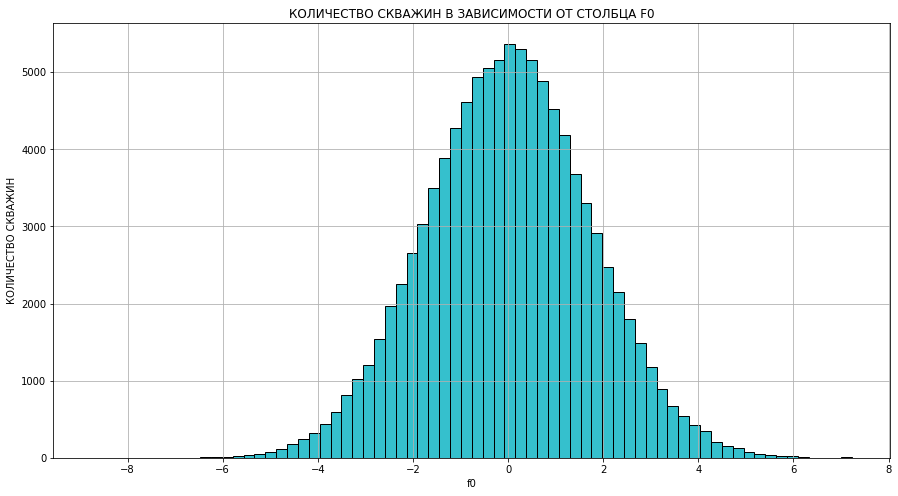

In [42]:
hist_graf(data3['f0'], 
          'f0', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F0', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f0', 
          70)

Минимальное значение: -8.7, максимальное: 7.2. Гистограмма с нормальным распределением. Медиана и среднее близки.

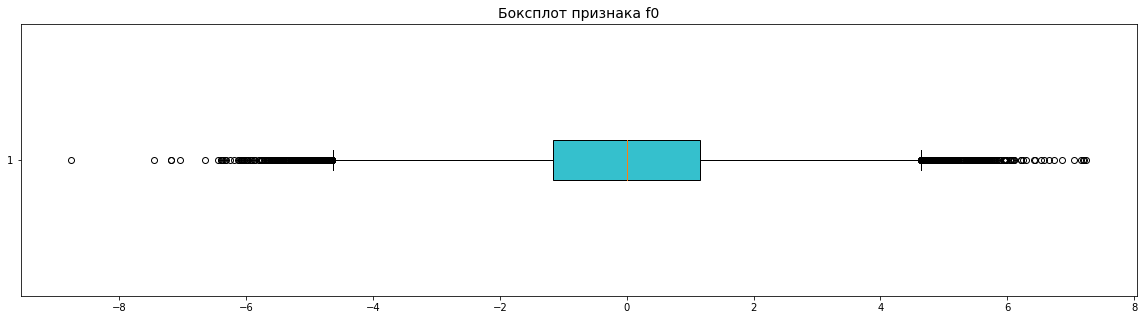



Пороговые значения f0:
Нижняя граница значений: -4.643524223522959
Верхняя граница значений: 4.639771092118378


In [43]:
boxplot_graf(data3['f0'], 'f0')

In [44]:
len(data3[data3['f0'] < -5]) + len(data3[data3['f0'] > 5])

382

Есть выбросы, 382 строки. Мало скважин с параметрами f0 меньше -5 и больше 5.


Описание признака f1:

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64



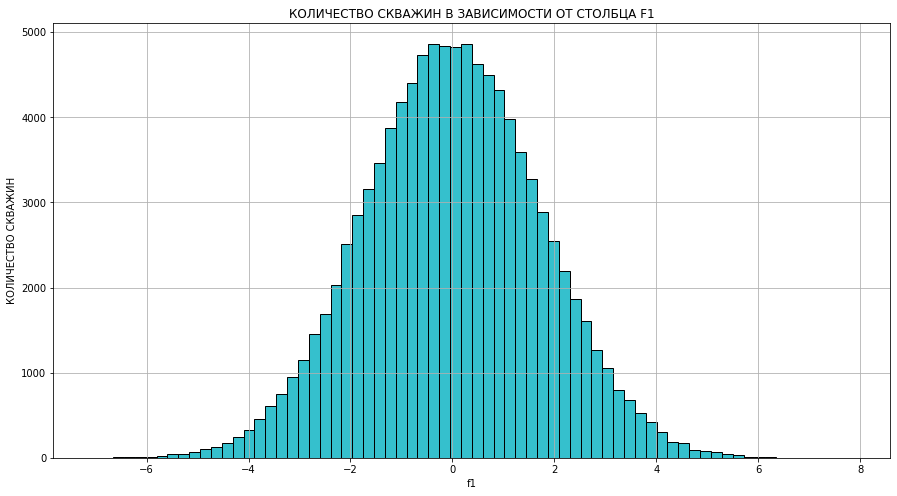

In [45]:
hist_graf(data3['f1'], 
          'f1', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F1', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f1', 
          70)

Минимальное значение: -7.0, максимальное: 7.8. Гистограмма с нормальным распределением. Медиана и среднее близки.

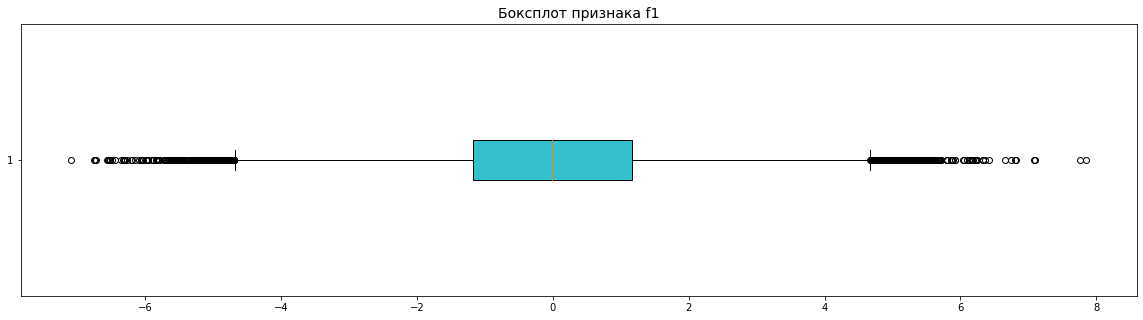



Пороговые значения f1:
Нижняя граница значений: -4.682565825428671
Верхняя граница значений: 4.671424081839961


In [46]:
boxplot_graf(data3['f1'], 'f1')

In [47]:
len(data3[data3['f1'] < -5]) + len(data3[data3['f1'] > 5])

388

Есть выбросы, 388 строк. Мало скважин с параметрами f1 меньше -5 и больше 5.


Описание признака f2:

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64



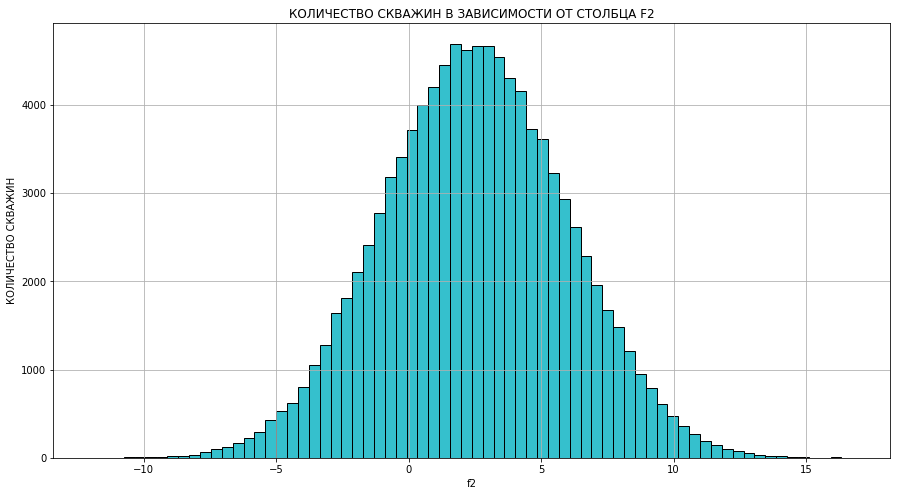

In [48]:
hist_graf(data3['f2'], 
          'f2', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ СТОЛБЦА F2', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'f2', 
          70)

Минимальное значение: -11.9, максимальное: 16.7. Гистограмма с нормальным распределением. Медиана и среднее близки.

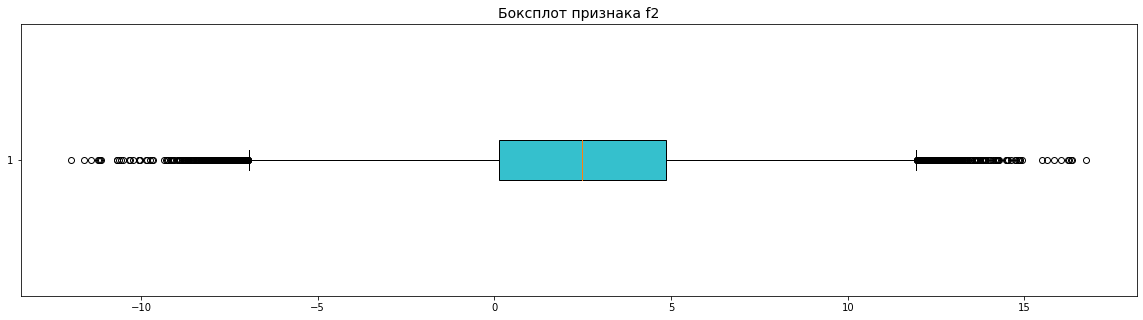



Пороговые значения f2:
Нижняя граница значений: -6.962293786328402
Верхняя граница значений: 11.951446027690594


In [49]:
boxplot_graf(data3['f2'], 'f2')

In [50]:
len(data3[data3['f2'] < -7])+len(data3[data3['f2'] > 12])

567

Есть выбросы, 567 строк. Мало скважин с параметрами f2 меньше -7 и больше 12.


Описание признака "объём запасов в скважине":

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64



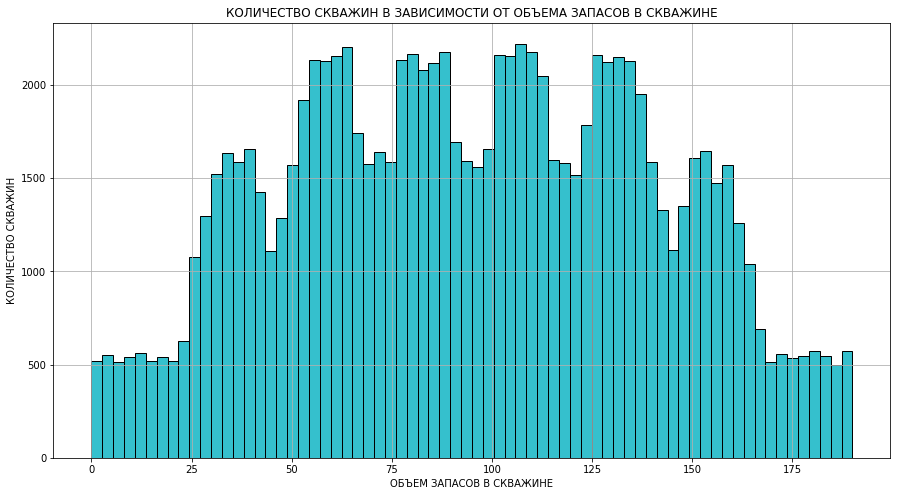

In [51]:
hist_graf(data3['product'], 
          '"объём запасов в скважине"', 
          'КОЛИЧЕСТВО СКВАЖИН В ЗАВИСИМОСТИ ОТ ОБЪЕМА ЗАПАСОВ В СКВАЖИНЕ', 
          'КОЛИЧЕСТВО СКВАЖИН', 
          'ОБЪЕМ ЗАПАСОВ В СКВАЖИНЕ', 
          70)

In [52]:
len(data3[data3['product'] == 0])

1

Одна скважина с нулевым объемом запасов нефти.

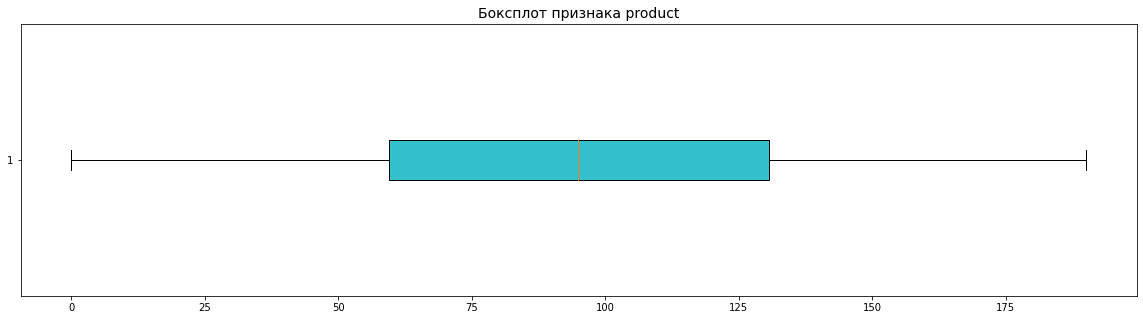



Пороговые значения product:
Нижняя граница значений: -47.26643772727831
Верхняя граница значений: 237.31190538130107


In [53]:
boxplot_graf(data3['product'], 'product')

Выбросов нет.

### Вывод

В данном разделе был проведён исследовательский анализ данных. 

Обнаружено:
* В регионе 1 наблюдается умеренная положительная корреляция (0.48) между объемом запасов скважин и столбцом f2, а также умеренная отрицательная корреляция (-0.44) между признаками f0 и f1.
* В регионе 2 наблюдается весьма высокая корреляция (1) между объемом запасов скважин и столбцом f2.
* В регионе 3 наблюдается умеренная корреляция (0.45) между объемом запасов скважин и столбцом f2.

По всем данным изучили гистограммы и проверили признаки на выбросы.

По **региону 1**:
* обнаружены выбросы в столбце f2 в количестве 247 строк;
* одна скважина оказалась c нулевым запасом нефти.

По **региону 2**:
* обнаружены выбросы в столбце f1 в количестве 441 строка;
* 8235 скважин c нулевым запасом нефти.

По **региону 3**:
* обнаружены выбросы в столбце f0 в количестве 382 строки;
* обнаружены выбросы в столбце f1 в количестве 388 строк;
* обнаружены выбросы в столбце f2 в количестве 567 строк;
* одна скважина c нулевым запасом нефти.

Выбросы трогать не стали, т.к. возможно, именно благодаря одной из этих скважин получится извлечь реальную выгоду.
Часто скважины бурят там, где заведомо нет нефти (для уточнения параметров и т.д.). Возможно, данные из этих скважин попали к нам. Оставили без изменений.

## Обучение и проверка модели

Создадим функцию, чтобы разделить данные по регионам на выборки.

In [54]:
def parts(df):
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    
    # разделение на выборки 
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    #масштабирование
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid   

### Деление на выборки

Деление данных на features и target для **региона 1**

In [55]:
warnings.filterwarnings('ignore')

features_train_1, features_valid_1, target_train_1, target_valid_1 = parts(data1)

print(features_train_1.shape)
print(features_valid_1.shape)
print(target_train_1.shape)
print(target_valid_1.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [56]:
features_train_1.head(5)

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181


In [57]:
features_valid_1.head(5)

,f0,f1,f2
71751,0.517917,-0.610097,-0.126226
80493,0.568391,-0.086063,-0.814914
2655,0.805688,-1.613289,-1.341342
53233,0.222503,-1.355437,-0.597275
91141,-0.087941,1.433113,-0.544588


Деление данных на features и target для **региона 2**

In [58]:
warnings.filterwarnings('ignore')

features_train_2, features_valid_2, target_train_2, target_valid_2 = parts(data2)

print(features_train_2.shape)
print(features_valid_2.shape)
print(target_train_2.shape)
print(target_valid_2.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [59]:
features_train_2.head(5)

,f0,f1,f2
27212,-0.850855,0.624428,0.296943
7866,1.971935,1.832275,0.294333
62041,1.079305,0.170127,-0.296418
70185,-1.512028,-0.887837,-0.880471
82230,-1.804775,-0.718311,-0.293255


In [60]:
features_valid_2.head(5)

,f0,f1,f2
71751,-0.168616,0.571372,0.297471
80493,0.878384,-1.772903,-0.293901
2655,-0.852976,-0.004986,-0.876502
53233,1.496940,-1.146077,-0.294011
91141,0.552177,0.057961,-1.457764


Деление данных на features и target для  **региона 3**

In [61]:
warnings.filterwarnings('ignore')

features_train_3, features_valid_3, target_train_3, target_valid_3 = parts(data3)

print(features_train_3.shape)
print(features_valid_3.shape)
print(target_valid_3.shape)
print(target_valid_3.shape)

(75000, 3)
(25000, 3)
(25000,)
(25000,)


In [62]:
features_train_3.head(5)

,f0,f1,f2
27212,-0.526160,0.776329,-0.400793
7866,-0.889625,-0.404070,-1.222936
62041,-1.133984,0.208576,0.296765
70185,1.227045,1.570166,-0.764556
82230,-0.194289,0.878312,0.840821


In [63]:
features_valid_3.head(5)

,f0,f1,f2
71751,-0.836717,-2.227439,-0.078489
80493,-0.821648,0.740237,-1.000811
2655,-2.651336,-0.235721,-0.244546
53233,1.077998,0.938090,0.511313
91141,-1.173938,2.387270,1.034363


### Обучение модели

Создадим функцию, которая поможет найти реальный средний запас сырья, предсказанный средний запас сырья и среднеквадратическую ошибку RMSE, чтобы изучить точность прогнозирования.

In [64]:
def LR(prediction, target, model, num):
    mean_real = target.mean()
    mean_pred = prediction.mean()
    rmse = np.sqrt(((prediction - target) ** 2).mean())
    print('Регион', num)
    print()
    print('Реальный средний запас сырья:', round(mean_real,2))
    print('Предсказанный средний запас сырья:',round(mean_pred,2))
    print('RMSE:', round(rmse,2))

Обучим модель для каждого региона и найдем все необходимые показатели.

In [65]:
model_1 = LinearRegression().fit(features_train_1, target_train_1)
prediction_1 = pd.Series(model_1.predict(features_valid_1), index=target_valid_1.index)

LR(prediction_1, target_valid_1, model_1, 1)

Регион 1

Реальный средний запас сырья: 92.08
Предсказанный средний запас сырья: 92.59
RMSE: 37.58


In [66]:
model_2 = LinearRegression().fit(features_train_2, target_train_2)
prediction_2 = pd.Series(model_2.predict(features_valid_2), index=target_valid_2.index)

LR(prediction_2, target_valid_2, model_2, 2)

Регион 2

Реальный средний запас сырья: 68.72
Предсказанный средний запас сырья: 68.73
RMSE: 0.89


In [67]:
model_3 = LinearRegression().fit(features_train_3, target_train_3)
prediction_3 = pd.Series(model_3.predict(features_valid_3), index=target_valid_3.index)

LR(prediction_3, target_valid_3, model_3, 3)

Регион 3

Реальный средний запас сырья: 94.88
Предсказанный средний запас сырья: 94.97
RMSE: 40.03


### Вывод

В данном разделе обучали модели по каждому региону. Для этого данные были разделены на обучающую и валидационную выборки. Все модели были обучены, а затем для данных каждого региона найдены: реальный средний запас сырья, предсказанный средний запас сырья и среднеквадратическая ошибка RMSE.

Результаты:

* **Регион 1**:
 - Реальный средний запас сырья: 92.08
 - Предсказанный средний запас сырья: 92.59
 - RMSE: 37.58
 
 
* **Регион 2**:
 - Реальный средний запас сырья: 68.72
 - Предсказанный средний запас сырья: 68.73
 - RMSE: 0.89
 
* **Регион 3**:
 - Реальный средний запас сырья: 94.88
 - Предсказанный средний запас сырья: 94.97
 - RMSE: 40.03


Величина отклонения предсказанного среднего запаса сырья от реального среднего запаса сырья для регионов 1 и 3 примерно одинаковая. Самую большую точность прогноза показала модель региона 2.

## Подготовка к расчёту прибыли

Зададим переменные для входных данных.

In [68]:
COUNT_SKV = 500 # количество скважин, которое исследуют при разведке региона
BEST_CHOICE = 200 # количество лучших скважин, которые нужно выбрать
BUDGET = 10000000000 # бюджет на разработку скважин в регионе 
PRICE = 450000 # Доход с каждой единицы продукта (руб.)
THRESHOLD = 0.025

Посчитаем объем сырья, который необходим для безубыточной разработки.

In [69]:
val = BUDGET / (PRICE * BEST_CHOICE)
print('Для безубыточной разработки необходимо', round(val,2), 'тыс. баррелей сырья.')

Для безубыточной разработки необходимо 111.11 тыс. баррелей сырья.


Для каждого региона найдем средний запас сырья.

In [70]:
def prib (reg, df):
    print(f'Регион {reg}:')
    print()
    print(f'Средний запас: {df["product"].mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше необходимого: {len(df.query("product > @val")) / len(df):.2%}')
    print(f'Количество скважин с объёмом больше необходимого: {len(df.query("product > @val"))}')

In [71]:
prib ('1', data1)

Регион 1:

Средний запас: 92.50 тыс. баррелей.
Процент скважин с объёмом больше необходимого: 36.58%
Количество скважин с объёмом больше необходимого: 36583


In [72]:
prib ('2', data2)

Регион 2:

Средний запас: 68.83 тыс. баррелей.
Процент скважин с объёмом больше необходимого: 16.54%
Количество скважин с объёмом больше необходимого: 16537


In [73]:
prib ('3', data3)

Регион 3:

Средний запас: 95.00 тыс. баррелей.
Процент скважин с объёмом больше необходимого: 38.18%
Количество скважин с объёмом больше необходимого: 38178


### Вывод

На данном этапе подготовились к расчету прибыли. Задали переменные для входных значений. Определили, что для безубыточной разработки необходимо 111.11 тыс. баррелей сырья.
Далее нашли средний запас сырья в каждом регионе. Результаты:

* **Регион 1**:
 - Средний запас: 92.50 тыс. баррелей
 - Процент скважин с объёмом больше необходимого: 36.58%
 - Количество скважин с объёмом больше необходимого: 36583
 
 
* **Регион 2**:
 - Средний запас: 68.83 тыс. баррелей.
 - Процент скважин с объёмом больше необходимого: 16.54%
 - Количество скважин с объёмом больше необходимого: 16537
 
* **Регион 3**:
 - Средний запас: 95.00 тыс. баррелей.
 - Процент скважин с объёмом больше необходимого: 38.18%
 - Количество скважин с объёмом больше необходимого: 38178
 
 Как мы видим, средние запасы сырья во всех регионах ниже необходимого порога. Но в каждом регионе есть определённый процент скважин с объёмом больше указанного порога в 111.11 тыс. баррелей сырья. Поэтому необходимо выявить наиболее выгодные скважины в каждом регионе.

## Расчёт прибыли и рисков 

Создадим функцию, которая будет сортировать скважины по значениям предсказаний, а затем отберёт нужное количество (в нашем случае 200 скважин) и рассчитает выручку.

In [74]:
def revenue(target, probabilities, count, pr):
    sort_skv = probabilities.sort_values(ascending=False)
    selected = target[sort_skv.index][:count]
    return pr * selected.sum() - BUDGET

Теперь создадим функцию техники Bootstrap. Сгенерируем 1000 выборок. Внутри каждой выборки с помощью функции revenue, посчитаем выручку и оценим: среднюю выручку, доверительный интервал, риск получения убытков. Распределение по каждому региону визуализируем.

In [75]:
state = np.random.RandomState(12345)

In [92]:
def bootstrap(target, valid, count, state):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=count, replace=True, random_state=state)
        probs_subsample = valid[target_subsample.index]
        a = revenue(target_subsample, probs_subsample, BEST_CHOICE, PRICE)
        values.append(a)
        
    values = pd.Series(values)
    
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean() * 100

    print("Средняя выручка с 200-т лучших скважин:", round(mean,2))
    print("Доверительный интервал (95%):", [lower, upper])
    print("Риск получения убытков:", risk)
    
    values.hist(figsize=(15, 8), bins=70, color='#35c0cd', edgecolor='black')
    plt.grid(True)
    plt.axvline(values.quantile(0.025), color='red')
    plt.axvline(values.quantile(0.975), color='green')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', f'Распределение прибыли для региона'])
    plt.xlabel('ППРИБЫЛЬ (руб.)')
    plt.ylabel('КОЛИЧЕСТВО СКВАЖИН (из 200-т лучших)')
    plt.title(f'РАСПРЕДЕЛЕНИЕ ПРИБЫЛИ')
    plt.show()

**Результаты для региона 1:**

Средняя выручка с 200-т лучших скважин: 417738641.09
Доверительный интервал (95%): [894137159.6916988]
Риск получения убытков: 417738641.0892107


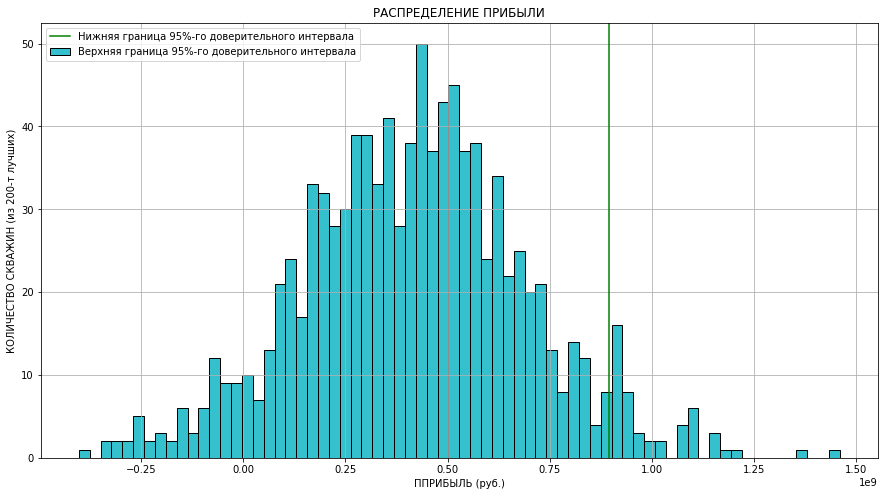

In [93]:
bootstrap(target_valid_1, prediction_1, COUNT_SKV, state)

**Результаты для региона 2:**

Средняя выручка с 200-т лучших скважин: 518259493.7
Доверительный интервал (95%): [128123231.43308444, 953612982.0669085]
Риск получения убытков: 0.3


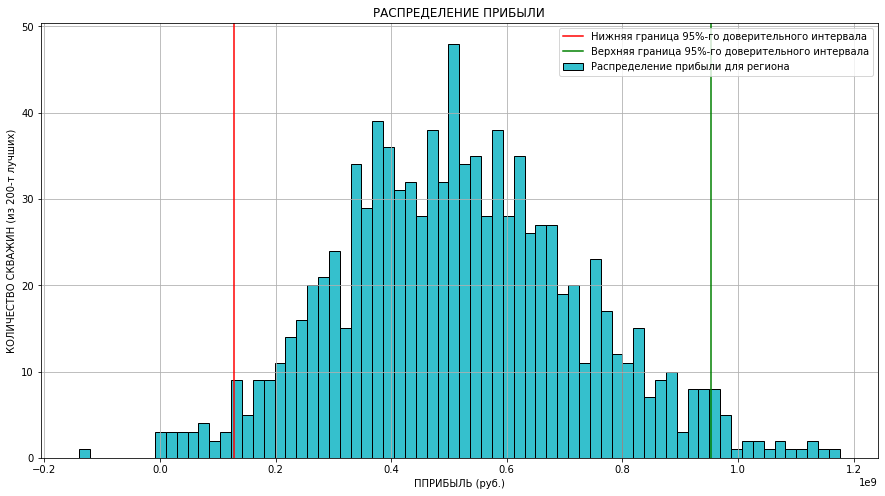

In [78]:
bootstrap(target_valid_2, prediction_2, COUNT_SKV, state)

**Результаты для региона 3:**

Средняя выручка с 200-т лучших скважин: 420194005.34
Доверительный интервал (95%): [-115852609.16001143, 989629939.8445739]
Риск получения убытков: 6.2


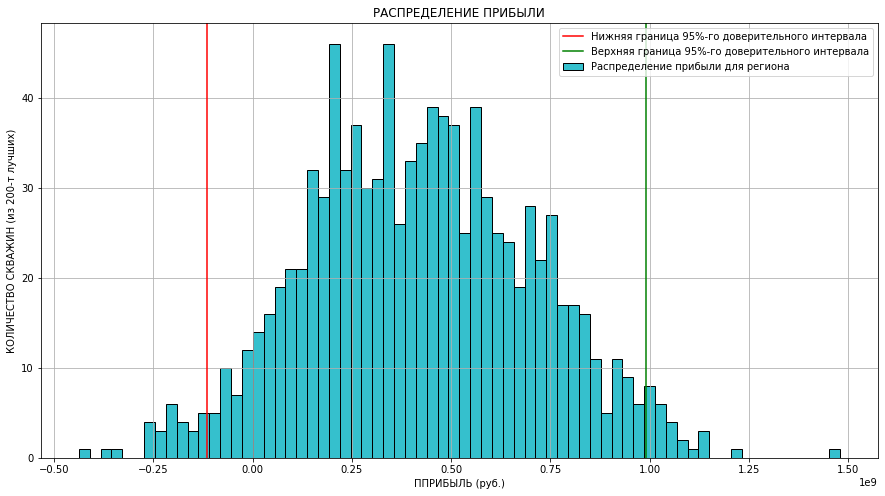

In [79]:
bootstrap(target_valid_3, prediction_3, COUNT_SKV, state)

### Вывод

На данном этапе рассчитали прибыли и риски, учитывая, что компания исследует 500 точек, а разработает 200 лучших.

Результат:

* **Регион 1**:
 - Средняя выручка с 200-т лучших скважин: 425938526.91
 - доверительный интервал (95%): [-102090094.83793654, 947976353.3583689]
 - Риск получения убытков: 6.0
 
 
* **Регион 2**:
 - Средняя выручка с 200-т лучших скважин: 518259493.7
 - Доверительный интервал (95%): [128123231.43308444, 953612982.0669085]
 - Риск получения убытков: 0.3
 
* **Регион 3**:
- Средняя выручка с 200-т лучших скважин: 420194005.34
- Доверительный интервал (95%): [-115852609.16001143, 989629939.8445739]
- Риск получения убытков: 6.2

Как видно, все три региона являются прибыльными. Самая высокая выручка из 200-т лучших скважин в регионе 2. Доверительный интервал уже и, риск получения убытков меньше также в регионе 2. В регионе 1 и в регионе 2 высока вероятность убытков значительно выше. Таким образом по всем показателям наиболее выгодный регион для разработки - регион 2. 

## Общий вывод

Перед нами была поставлена **задача**: определить регион с максимальной суммарной прибылью отобранных скважин.

Для решения задачи были предоставлены данные в виде трёх датасетов (по 3-м регионам соответственно). Данные были загружены и изучены на наличие пропущенных значений и дубликатов. Пропущенные значения в данных не найдены. В каждом датафрейме найдены дубликаты по уникальному идентификатору. Получается, что из некоторых скважин пробы брали несколько раз. По сумме ключевых параметров дубликаты не найдены. Т.к. не было возможность уточнить, какие данные верные, а какие нет, было принято решение дубликаты не трогать.

Во время **исследовательского анализа** данных обнаружено:

* В **регионе 1** наблюдается умеренная положительная корреляция (0.48) между объемом запасов скважин и столбцом f2, а также умеренная отрицательная корреляция (-0.44) между признаками f0 и f1.
* В **регионе 2** наблюдается весьма высокая корреляция (1) между объемом запасов скважин и столбцом f2.
* В **регионе 3** наблюдается умеренная корреляция (0.45) между объемом запасов скважин и столбцом f2.

Также по всем данным были **изучены гистограммы** и проверены признаки на **выбросы**.

По **региону 1** обнаружили выбросы в столбце f2 в количестве 247 строк, а также одну скважину с нулевым запасом нефти.

По **региону 2** обнаружили выбросы в столбце  f1 в количестве 441 строки, а также 8235 скважин c нулевым запасом нефти.

По **региону 3** обнаружили выбросы в столбце f0 в количестве 382 строки, выбросы в столбце f1 в количестве 388 строк,  выбросы в столбце f2 в количестве 567 строк, а также одну скважину с нулевым запасом нефти.

Выбросы трогать не стали. Скважины с  нулевым запасом нефти также оставили без изменений.

Далее перешли к **обучению модели**. Данные были разделены на обучающую и валидационную выборки. Все модели были обучены, а затем для данных каждого региона найдены: реальный средний запас сырья, предсказанный средний запас сырья и среднеквадратическая ошибка RMSE.

Результаты:

**Регион 1:**
Реальный средний запас сырья: 92.08
Предсказанный средний запас сырья: 92.59
RMSE: 37.58

**Регион 2:**
Реальный средний запас сырья: 68.72
Предсказанный средний запас сырья: 68.73
RMSE: 0.89

**Регион 3:**
Реальный средний запас сырья: 94.88
Предсказанный средний запас сырья: 94.97
RMSE: 40.03

Величина отклонения предсказанного среднего запаса сырья от реального среднего запаса сырья для регионов 1 и 3 примерно одинаковая. Самую большую точность прогноза показала модель региона 2.

На следующем этапе подготовились к **расчету прибыли**. Задали переменные для входных значений. Определили, что для безубыточной разработки необходимо **111.11 тыс. баррелей сырья**, нашли средний запас сырья в каждом регионе. 

Результаты:

* **Регион 1**:
 - Средний запас: **92.50 тыс. баррелей**
 - Процент скважин с объёмом больше необходимого: 36.58%
 - Количество скважин с объёмом больше необходимого: 36583
 
 
* **Регион 2**:
 - Средний запас: **68.83 тыс. баррелей**
 - Процент скважин с объёмом больше необходимого: 16.54%
 - Количество скважин с объёмом больше необходимого: 16537
 
* **Регион 3**:
 - Средний запас: **95.00 тыс. баррелей**
 - Процент скважин с объёмом больше необходимого: 38.18%
 - Количество скважин с объёмом больше необходимого: 38178
 
Средние запасы сырья во всех регионах оказались ниже необходимого порога. Перешли к выявлению наиболее выгодных скважин в каждом регионе. Рассчитали прибыли и риски, учитывая, что компания исследует 500 точек, а разработает 200 лучших.

Результат:

* **Регион 1**:
 - Средняя выручка с 200-т лучших скважин: 425938526.91
 - доверительный интервал (95%): [-102090094.83793654, 947976353.3583689]
 - Риск получения убытков: 6.0
 
 
* **Регион 2**:
 - Средняя выручка с 200-т лучших скважин: 518259493.7
 - Доверительный интервал (95%): [128123231.43308444, 953612982.0669085]
 - Риск получения убытков: 0.3
 
* **Регион 3**:
- Средняя выручка с 200-т лучших скважин: 420194005.34
- Доверительный интервал (95%): [-115852609.16001143, 989629939.8445739]
- Риск получения убытков: 6.2

Как видно, все три региона являются прибыльными. Самая высокая выручка из 200-т лучших скважин в регионе 2. Доверительный интервал уже и, риск получения убытков меньше также в регионе 2. В регионе 1 и в регионе 2 высока вероятность убытков значительно выше. Таким образом по всем показателям **наиболее выгодный регион для разработки - регион 2**. 